In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import dspy
from dspy.datasets import DataLoader
from dspy.teleprompt import LabeledFewShot
from dspy.evaluate import Evaluate
from dspy.evaluate.metrics import answer_exact_match
from typing import List, Any, Optional


In [3]:
lm = dspy.LM(model="openai/Qwen/Qwen2-VL-7B-Instruct", api_base="http://localhost:8000/v1", api_key="sk-proj-1234567890")

# adapter = dspy.ChatAdapter()
dspy.settings.configure(lm=lm)

In [29]:
input_keys = tuple([f"image_{i}" for i in range(1, 3)] + ["question", "options"])
subsets = ['Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art', 'Art_Theory', 'Basic_Medical_Science', 'Biology', 'Chemistry', 'Clinical_Medicine', 'Computer_Science', 'Design', 'Diagnostics_and_Laboratory_Medicine', 'Economics', 'Electronics', 'Energy_and_Power', 'Finance', 'Geography', 'History', 'Literature', 'Manage', 'Marketing', 'Materials', 'Math', 'Mechanical_Engineering', 'Music', 'Pharmacy', 'Physics', 'Psychology', 'Public_Health', 'Sociology']

devset = []
valset = []
for subset in subsets:
    devset.extend(DataLoader().from_huggingface("MMMU/MMMU", subset, split=["dev"], input_keys=input_keys)["dev"])
    valset.extend(DataLoader().from_huggingface("MMMU/MMMU", subset, split=["validation"], input_keys=input_keys)["validation"])

In [33]:
def count_images(dataset):
    image_counts = {i: 0 for i in range(3)}  # Initialize counts for 0 to 2 images
    for example in dataset:
        count = sum(1 for key in example.inputs().keys() if key.startswith('image_') and example.inputs()[key] is not None)
        if count <= 2:
            image_counts[count] += 1
    return image_counts

devset = [example for example in devset if sum(1 for key in example.inputs().keys() if key.startswith('image_') and example.inputs()[key] is not None) <= 2]
valset = [example for example in valset if sum(1 for key in example.inputs().keys() if key.startswith('image_') and example.inputs()[key] is not None) <= 2]

devset_image_counts = count_images(devset)
valset_image_counts = count_images(valset)

print("Image counts in devset:")
for count, num_examples in devset_image_counts.items():
    print(f"{count} image(s): {num_examples} examples")

print("\nImage counts in valset:")
for count, num_examples in valset_image_counts.items():
    print(f"{count} image(s): {num_examples} examples")


Image counts in devset:
0 image(s): 0 examples
1 image(s): 146 examples
2 image(s): 2 examples

Image counts in valset:
0 image(s): 0 examples
1 image(s): 857 examples
2 image(s): 24 examples


In [36]:
Image = Any
class MMMUSignature(dspy.Signature):
    """Output a rationale and the answer to a multiple choice question about an image."""

    question: str = dspy.InputField(desc="A question about the image(s)")
    image_1: Optional[Image] = dspy.InputField(desc="An image of a math problem")
    image_2: Optional[Image] = dspy.InputField(desc="An image of a math problem")
    options: List[str] = dspy.InputField(desc="The options to the question")
    answer: str = dspy.OutputField(desc="The answer to the question")

predictor = dspy.ChainOfThought(MMMUSignature, temperature=0.0)
# print(predictor(question="What is the capital of france?"))

got outputs ['[[[[ #### rationale #### ]]]]\nTo find the missing amounts for company B, we need to use the accounting equation: Revenues - Expenses = Net Income or (Loss). We can rearrange this equation to find the missing amounts: Revenues = Expenses + Net Income or (Loss). We can then use this equation to find the missing amounts for company B.\n\n[[[[ #### answer #### ]]]]\n$71,320']
Prediction(
    rationale='To find the missing amounts for company B, we need to use the accounting equation: Revenues - Expenses = Net Income or (Loss). We can rearrange this equation to find the missing amounts: Revenues = Expenses + Net Income or (Loss). We can then use this equation to find the missing amounts for company B.',
    answer='$71,320'
)
got outputs ["[[[[ #### rationale #### ]]]]\nThe ending balance in the owners' capital account is calculated by adding the beginning balance to the net income (revenue minus expenses). The net income is $56,400 - $59,800 = -$3,400. Therefore, the ending 
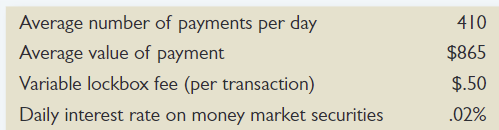

ValueError: Expected dict_keys(['rationale', 'answer']) but got dict_keys([])

In [37]:
# sample_input=devset[0]
results = []
for sample_input in devset[:10]:
    x = predictor(**sample_input.inputs())
    results.append(x)
    print(x)

In [ ]:
# print(len(devset))
# print(devset)

optimizer = LabeledFewShot(k=3)
bootstrapped_predictor = optimizer.compile(predictor, trainset=devset, sample=False)
# print(sample_input.inputs())
# print(encode_image(sample_input.inputs()["image_1"]))
# print(sample_input.inpi)
# print(bootstrapped_predictor(**sample_input.inputs()))

# evaluate = Evaluate(metric=answer_exact_match, num_threads=300, devset= valset, display_progress=True)
# print(evaluate(bootstrapped_predictor))

In [ ]:
test_input = dataset["dev"][0]
test_input